In [78]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import time
import pickle
import datetime

import sys
sys.path.append('/home/ngrav/project/')
from wearables.scripts import utils as wearutils
from wearables.scripts import data as weardata
from wearables.scripts import train as weartrain
from wearables.scripts import eval_ as weareval
from wearables.scripts import model as wearmodels
from wearables.scripts import DTW as weardtw

import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy.stats import spearmanr
from scipy.stats import chi2_contingency
from scipy.stats import kruskal
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.regression.compose._ensemble import ComposableTimeSeriesForestRegressor
from sktime.classification.compose import ComposableTimeSeriesForestClassifier

plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=1
plt.rcParams['savefig.dpi'] = 600
sns.set_style("ticks")

In [2]:
def loadpkl(fp):
    with open(fp, 'rb') as f:
        return pickle.load(f)

In [3]:
# load data

pfp = '/home/ngrav/project/wearables/results/'
mfp = '/home/ngrav/project/wearables/model_zoo'

# filepaths to bst or pre-processed md with calculated metrics 
pp_md_fp = os.path.join(pfp, 'md_v522_220124.csv')
bst_trainer = os.path.join(mfp, 'trainer_itv52_InceptionTime_GA5.pkl')
bst_modelpkl = os.path.join(mfp, '213-itv52_InceptionTime_GA5.pkl')

# load up to date md
md = pd.read_csv(pp_md_fp, index_col=0)
trainer = loadpkl(bst_trainer)

if False:
    # call eval to get output, modify for return_hidden = True option
    evaluation = weareval.eval_trained(trainer, split='train',
                                       modelpkl=bst_modelpkl,
                                       two_outputs=True)

# show error in train and test set 

In [4]:
# define parameters
idxs = trainer.data.train_ids
threshold = 8 # for error groups

Text(0.5, 1.0, 'Train set error')

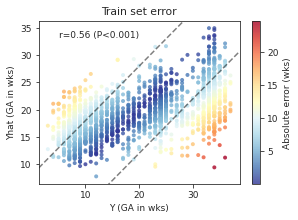

In [5]:
# parse data and plot
y = md.loc[idxs, 'y']
yhat = md.loc[idxs, 'yhat']
error = md.loc[idxs, 'error']

fig, ax = plt.subplots(1, 1, figsize=(4.5, 3))
im = ax.scatter(y, yhat, c=error.abs(), cmap='RdYlBu_r', linewidth=0, s=16, alpha=0.8)
fig.colorbar(im, ax=ax, label='Absolute error (wks)')
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.plot([x0, x1], [x0+threshold, x1+threshold], 'k--', alpha=0.5)
ax.plot([x0, x1], [x0-threshold, x1-threshold], 'k--', alpha=0.5)
ax.set_xlim([x0, x1])
ax.set_ylim([y0, y1])
rho, p = spearmanr(y, yhat)
p_txt = 'P={:.2f}'.format(p) if p > 0.001 else 'P<0.001'
ax.text(0.1, 0.9, 'r={:.2f} ({})'.format(rho, p_txt), transform=ax.transAxes) 
ax.set_xlabel('Y (GA in wks)')
ax.set_ylabel('Yhat (GA in wks)')
ax.set_title('Train set error')

### assign error grp

In [6]:
md['Error group'] = 'lt{}wks'.format(threshold)
md.loc[(md['error'] >= threshold), 'Error group'] = 'Higher-than-actual'
md.loc[(md['error'] <= -threshold), 'Error group'] = 'Lower-than-actual'


In [7]:
md.loc[idxs, 'Error group'].value_counts()

lt8wks                1053
Lower-than-actual      360
Higher-than-actual     313
Name: Error group, dtype: int64

In [8]:
errgrp_cmap = {'lt{}wks'.format(threshold): '#4297A0', # green
               'Higher-than-actual': '#E57F84', #red
               'Lower-than-actual': '#2F5061', # blue
               }

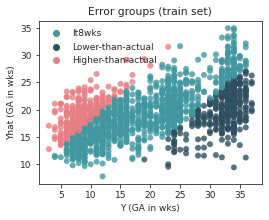

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.scatterplot(x='y', y='yhat', hue='Error group', data=md.loc[idxs], palette=errgrp_cmap, linewidth=0, alpha=0.8, ax=ax)
ax.set_xlabel('Y (GA in wks)')
ax.set_ylabel('Yhat (GA in wks)')
ax.set_title('Error groups (train set)')
ax.legend().set_title('')

## chk the same in the test set m

In [10]:
# define parameters
idxs = trainer.data.test_ids

Text(0.5, 1.0, 'Test set error')

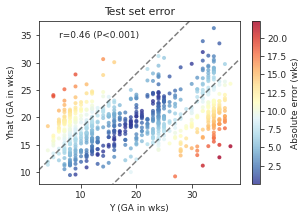

In [11]:
# parse data and plot
y = md.loc[idxs, 'y']
yhat = md.loc[idxs, 'yhat']
error = md.loc[idxs, 'error']

fig, ax = plt.subplots(1, 1, figsize=(4.5, 3))
im = ax.scatter(y, yhat, c=error.abs(), cmap='RdYlBu_r', linewidth=0, s=16, alpha=0.8)
fig.colorbar(im, ax=ax, label='Absolute error (wks)')
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.plot([x0, x1], [x0+threshold, x1+threshold], 'k--', alpha=0.5)
ax.plot([x0, x1], [x0-threshold, x1-threshold], 'k--', alpha=0.5)
ax.set_xlim([x0, x1])
ax.set_ylim([y0, y1])
rho, p = spearmanr(y, yhat)
p_txt = 'P={:.2f}'.format(p) if p > 0.001 else 'P<0.001'
ax.text(0.1, 0.9, 'r={:.2f} ({})'.format(rho, p_txt), transform=ax.transAxes) 
ax.set_xlabel('Y (GA in wks)')
ax.set_ylabel('Yhat (GA in wks)')
ax.set_title('Test set error')

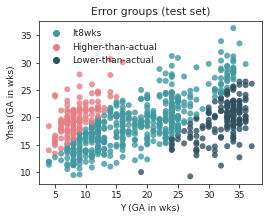

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.scatterplot(x='y', y='yhat', hue='Error group', data=md.loc[idxs], palette=errgrp_cmap, linewidth=0, alpha=0.8, ax=ax)
ax.set_xlabel('Y (GA in wks)')
ax.set_ylabel('Yhat (GA in wks)')
ax.set_title('Error groups (test set)')
ax.legend().set_title('')

In [13]:
md.loc[idxs, 'Error group'].value_counts()

lt8wks                446
Lower-than-actual     164
Higher-than-actual    127
Name: Error group, dtype: int64

# md differences across err grp

In [79]:
# grab list of vars to predict (mdpred_voi)
from wearables.scripts.md_specification import mdpred_voi

In [151]:
class dataloader():
    '''Load data into numpy data types and specify number of folds. If kfold=1 or 0, then single val set returned.
    '''
    def __init__(self, target_name='GA', 
                 kfold=5, prop_trainset=1., 
                 include_lux=False, 
                 filename='/home/ngrav/data/wearables/processed/MOD1000_modeldata.pkl',
                 pp_md_fp=os.path.join(pfp, 'md_v522_220124.csv')):
        self.rawdata_file = filename
        self.data = self.load_preproced(filename)
        self.target_name = target_name
        self.kfold = kfold
        self.prop_trainset = prop_trainset
        self.include_lux = include_lux
        if pp_md_fp is not None:
            self.md = pd.read_csv(pp_md_fp, index_col=0)
        else:
            self.md = None
        self.ids = list(self.data['IDs'].keys())
        
        # split data and get dataloaders
        self.split_data()
        self.Xy_train, self.Xy_test = self.get_Xy(self.target_name)
        
    def load_preproced(self, filename):
        with open(filename, 'rb') as f:
            data = pickle.load(f)
            f.close()
        return data
    
    def split_data(self, train_ratio=0.8):
        pids = np.unique([i.split('_')[0] for i in self.data['IDs'].keys()])
        train_pids = np.random.choice(pids, int(len(pids)*train_ratio*self.prop_trainset), replace=False)
        test_pids = [i for i in pids if i not in train_pids]
        if self.kfold <= 1: # create single val set
            val_pids = np.random.choice(test_pids, int(len(test_pids)*0.5), replace=False)
            # no overlap between val/test? or merge val into test?
            # test_pids = [i for i in test_pids if i not in val_pids]
            self.val_ids = [i for i in self.data['IDs'].keys() if i.split('_')[0] in val_pids]
        else:
            self.train_ids = np.array_split(train_pids, self.kfold)
            for ii, fold in enumerate(self.train_ids):
                self.train_ids[ii] = [i for i in self.data['IDs'].keys() if i.split('_')[0] in self.train_ids[ii]]
        self.test_ids = [i for i in self.data['IDs'].keys() if i.split('_')[0] in test_pids]
        return None

    def Xy_from_id(self, ids, target_name):
        for i, k in enumerate(ids):
            if self.include_lux:
                x = np.concatenate((self.data['data'][k]['activity'].to_numpy(dtype=np.float32)[:-1].reshape(-1, 1), 
                                    self.data['data'][k]['light'].to_numpy(dtype=np.float32)[:-1].reshape(-1, 1)), 
                                    1) 
            else:
                x = self.data['data'][k]['activity'].to_numpy(dtype=np.float32)[:-1]
            if i==0:
                X = np.zeros(shape=(len(ids), *x.shape))
                y = np.zeros(shape=(len(ids), ))
            X[i] = x
            if target_name == 'GA':
                y[i] = np.float32(k.split('_')[-1])
            else:
                if self.md is None:
                    y[i] = np.float32(self.data['data'][k]['md'][target_name])
                else:
                    y[i] = np.float32(self.md.loc[k, target_name].item())
                    
        # define in terms of category class
        try:
            enc = self.data['cat_class_enc'][target_name]
        except KeyError:
            enc = None
        if enc is not None and len(enc.keys()) > 2:
            # force to wide 
            y_wide = np.zeros(shape=(y.shape[0], len(enc.keys())), dtype=np.float32)
            y_wide[np.arange(y.shape[0]), np.array(y, dtype=int)] = 1.
            y = y_wide # force multiclass classification, check cat_class_enc for meaning
        return X, y

    def get_Xy(self, target_name):
        # train, if CV, dict with [(X_train, y_train), (X_val, y_val)] else (X_train, y_train)
        Xy_test = self.Xy_from_id(self.test_ids, target_name)
        if self.kfold > 1:
            Xy_train = {}
            Xy_cv = {}
            for k, fold_ids in enumerate(self.train_ids):
                Xy_cv[k] = (self.Xy_from_id(fold_ids, target_name))
            # now concatenate others, shifting single to others
            for kfold in Xy_cv.keys():
                for i, kk in enumerate([k for k in Xy_cv.keys() if k != kfold]):
                    X, y = Xy_cv[kk]
                    if i==0:
                        X_cv, y_cv = X.copy(), y.copy()
                    else:
                        X_cv = np.concatenate((X_cv, X), 0)
                        y_cv = np.concatenate((y_cv, y), 0)
                Xy_train[kfold] = [(X_cv, y_cv), Xy_cv[kfold]]
            return Xy_train, Xy_test
        else:
            Xy_train = self.Xy_from_id(self.train_ids, target_name)
            Xy_val = self.Xy_from_id(self.val_ids, target_name)
            return Xy_train, Xy_val, Xy_test


In [152]:
class kNN():
    def __init__(self, n_trials=1, target_name='GA', tasktype='regression'):
        self.n_trials = n_trials
        self.target_name = target_name
        self.tasktype = tasktype
    
        
    def load_data(self):
        return dataloader(target_name=self.target_name)
        
    def fit(self, data):
        if data.kfold > 1:
            cv_eval = {}
            for k, cv_fold in enumerate(data.Xy_train.keys()):
                [(X_train, y_train), (X_val, y_val)] = data.Xy_train[cv_fold]
                kNN = KNeighborsRegressor(n_jobs=16) if self.tasktype=='regression' else KNeighborsClassifier(n_jobs=16)
                kNN.fit(X_train, y_train)
                eval_metrics = weareval.eval_output(kNN.predict(X_val), y_val, tasktype=self.tasktype)
                cv_eval[cv_fold] = {'model': kNN, 
                                    # 'data': [(X_train, y_train), (X_val, y_val)], # store just IDs?
                                    'metric': eval_metrics['mae'] if self.tasktype=='regression' else eval_metrics['balanced_acc_adj'],
                                    'metrics': eval_metrics}
            # retain only best model
            tmp = {cv_fold:cv_eval[cv_fold]['metric'] for cv_fold in cv_eval.keys()}
            bst_fold = min(tmp, key=tmp.get) if self.tasktype=='regression' else max(tmp, key=tmp.get)
            self.kNN = cv_eval[bst_fold]['model']
            return {'model': self.kNN, 'metrics': cv_eval[bst_fold]['metrics']}
        else:
            X_train, y_train = data.Xy_train
            X_val, y_val = data.Xy_val
            self.kNN = KNeighborsRegressor(n_jobs=12) if self.tasktype=='regression' else KNeighborsClassifier(n_jobs=12)
            self.kNN.fit(X_train, y_train)
            eval_metrics = weareval.eval_output(self.kNN.predict(X_val), y_val, tasktype=self.tasktype)
            return {'model': self.kNN, 'metrics': eval_metrics}
    
    def eval_test(self, data):
        X_test, y_test = data.Xy_test
        eval_metrics = weareval.eval_output(self.kNN.predict(X_test), y_test, tasktype=self.tasktype)
        return eval_metrics
    
    def del_model(self):
        del self.kNN
    
    def run_trials(self, verbose=False):
        if verbose:
            t_start = time.time()
            print('Starting kNN trials; predict {}'.format(self.target_name))
        results = {}
        for n in range(self.n_trials):
            if verbose:
                tic = time.time()
            data = self.load_data()
            self.fit(data)
            results[n] = self.eval_test(data)
            self.del_model()
            if verbose:
                print('  finished trial {} in {:.2f}-s\t{:.1f}-min elapsed'.format(n, time.time()-tic, (time.time()-t_start)/60))
        return results

In [153]:
class TSRF():
    def __init__(self, n_trials=1, target_name='GA', tasktype='regression'):
        self.n_trials = n_trials
        self.target_name = target_name
        self.tasktype = tasktype
    
        
    def load_data(self):
        return dataloader(target_name=self.target_name, )
        
    def fit(self, data):
        if data.kfold > 1:
            cv_eval = {}
            for k, cv_fold in enumerate(data.Xy_train.keys()):
                [(X_train, y_train), (X_val, y_val)] = data.Xy_train[cv_fold]
                X_train, X_val = from_2d_array_to_nested(X_train), from_2d_array_to_nested(X_val)
                tsf = ComposableTimeSeriesForestRegressor(
                    n_jobs=-1) if self.tasktype=='regression' else ComposableTimeSeriesForestClassifier(
                    n_jobs=-1)
                tsf.fit(X_train, y_train)
                eval_metrics = weareval.eval_output(tsf.predict(X_val), y_val, tasktype=self.tasktype)
                cv_eval[cv_fold] = {'model': tsf, 
                                    # 'data': [(X_train, y_train), (X_val, y_val)], # store just IDs?
                                    'metric': eval_metrics['mae'] if self.tasktype=='regression' else eval_metrics['balanced_acc_adj'],
                                    'metrics': eval_metrics}
            # retain only best model
            tmp = {cv_fold:cv_eval[cv_fold]['metric'] for cv_fold in cv_eval.keys()}
            bst_fold = min(tmp, key=tmp.get) if self.tasktype=='regression' else max(tmp, key=tmp.get)
            self.tsf = cv_eval[bst_fold]['model']
            return {'model': self.tsf, 'metrics': cv_eval[bst_fold]['metrics']}
        else:
            X_train, y_train = data.Xy_train
            X_val, y_val = data.Xy_val
            X_train, X_val = from_2d_array_to_nested(X_train), from_2d_array_to_nested(X_val)
            self.tsf = ComposableTimeSeriesForestRegressor(
                n_jobs=-1) if self.tasktype=='regression' else ComposableTimeSeriesForestClassifier(
                n_jobs=-1)
            self.tsf.fit(X_train, y_train)
            eval_metrics = weareval.eval_output(self.tsf.predict(X_val), y_val, tasktype=self.tasktype)
            return {'model': self.tsf, 'metrics': eval_metrics}
    
    def eval_test(self, data):
        X_test, y_test = data.Xy_test
        eval_metrics = weareval.eval_output(self.tsf.predict(X_test), y_test, tasktype=self.tasktype)
        return eval_metrics
    
    def del_model(self):
        del self.tsf
    
    def run_trials(self, verbose=False):
        if verbose:
            t_start = time.time()
            print('Starting TSRF trials; predict {}'.format(self.target_name))
        results = {}
        for n in range(self.n_trials):
            if verbose:
                tic = time.time()
            data = self.load_data()
            self.fit(data)
            results[n] = self.eval_test(data)
            self.del_model()
            if verbose:
                print('  finished trial {} in {:.2f}-s\t{:.1f}-min elapsed'.format(n, time.time()-tic, (time.time()-t_start)/60))
        return results

In [154]:
# statistical tests
def pd_chisq(df, feat, groupby='Error group'):
    obs = md.groupby([groupby, feat]).size().unstack(fill_value=0)
    chi2, p, dof, expected = chi2_contingency(obs)
    return p, obs, expected

def pd_kruskalwallis(df, feat, groupby='Error group'):
    size = []
    for i, g in enumerate(df[groupby].unique()):
        dt = df.loc[df[groupby]==g, feat].to_numpy()
        size.append(dt.shape[0])
        if i==0:
            X = dt
        else:
            X = np.concatenate((X, dt))
    X = np.split(X, np.cumsum(size[:-1]))
    statistic, p = kruskal(*X)
    return p, X


In [155]:
def stat_err_analysis(md, voi2pred, model=None, 
                      groupby='Error group', 
                      verbose=True,
                      out_file=None):
    '''Extract Pval from non-parametric test for cat/cont vars and predictability across metadata
    
    Arguments:
      md (pd.DataFrame): metadata where index is unique identifier to call dataset
      voi2pred (dict): specify column in md to predict as key; value is 'categorical' or 'continuous' to 
        trigger appropriate test and model
      
    '''
    res = dict()
    if verbose:
        if model is not None:
            print('Starting stat and predictability on {} vars'.format(len(list(voi2pred.keys()))))
        else:
            print('Starting stats on {} vars'.format(len(list(voi2pred.keys()))))
        tic = time.time()
    for i, (k, v) in enumerate(voi2pred.items()):
        if v == 'continuous':
            p, obs, exp = pd_chisq(md, k, groupby=groupby)
            res[k] = {'p': p, 'obs': obs, 'exp': exp}
        else:
            p, X = pd_kruskalwallis(md, k, groupby=groupby)
            #quants = {'q{}'.format(i):md.groupby(groupby)[col].quantile(i).to_dict() for i in [0.25, 0.5, 0.75]}
            res[k] = {'p': p, 'X': X}
        if model is not None:
            res[k]['predictability'] = model(target_name=k, tasktype='regression' if v=='continuous' else 'classification').run_trials()
        if verbose:
            print('  through {} vars in {:.0f}-s'.format(i+1, time.time() - tic))
    if out_file is not None:
        with open(out_file, 'wb') as f:
            pickle.dump(res, f, protocol=pickle.HIGHEST_PROTOCOL)
            f.close()
    return res

In [156]:
import importlib
importlib.reload(weareval)

<module 'wearables.scripts.eval_' from '/home/ngrav/project/wearables/scripts/eval_.py'>

In [ ]:
res = stat_err_analysis(md, mdpred_voi, out_file=os.path.join(pfp, 'md_predictability_knn.pkl'), model=kNN)

Starting stat and predictability on 122 vars
  through 1 vars in 8-s
  through 2 vars in 15-s
  through 3 vars in 23-s


/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:8

  through 4 vars in 32-s
  through 5 vars in 40-s
  through 6 vars in 48-s
  through 7 vars in 56-s
  through 8 vars in 64-s
  through 9 vars in 72-s
  through 10 vars in 79-s
  through 11 vars in 87-s
  through 12 vars in 96-s
  through 13 vars in 104-s
  through 14 vars in 113-s
  through 15 vars in 121-s
  through 16 vars in 128-s
  through 17 vars in 137-s
  through 18 vars in 144-s
  through 19 vars in 152-s
  through 20 vars in 161-s
  through 21 vars in 169-s
  through 22 vars in 176-s
  through 23 vars in 185-s
  through 24 vars in 193-s
  through 25 vars in 200-s
  through 26 vars in 208-s
  through 27 vars in 216-s
  through 28 vars in 225-s


In [165]:
res_tsrf = stat_err_analysis(md, {'IS': 'continuous'}, out_file=os.path.join(pfp, 'md_predictability_tsrf.pkl'), model=TSRF)

In [160]:
with open(os.path.join(pfp, 'md_predictability_knn.pkl'), 'rb') as f:
    resknn = pickle.load(f)
    f.close()

In [163]:
# metrics of interest
metric = ['auprc_adj', 'auprc_model']
moi = {m: [] for m in metric}
for k in resknn.keys():
    if any([True if 'balanced' in i else False for i in resknn[k]['predictability'][0].keys()]):
        for m in metric:
            moi[m].append(resknn[k]['predictability'][0]

{'age_enroll': {'p': 0.17662757928874764,
  'obs': age_enroll          18.0  19.0  20.0  21.0  22.0  23.0  24.0  25.0  26.0  \
  Error group                                                                
  Higher-than-actual    14    15    13    10    17    20    19    30    19   
  Lower-than-actual      5    17    19    24    14    32    29    29    40   
  lt8wks                28    48    45    46    60    53    79    62    94   
  
  age_enroll          27.0  ...  33.0  34.0  35.0  36.0  37.0  38.0  39.0  40.0  \
  Error group               ...                                                   
  Higher-than-actual    31  ...    27    22    14     8     8     6    11     6   
  Lower-than-actual     32  ...    28    15    20    14     8     8     6     4   
  lt8wks                95  ...    92    66    50    19    26    29    25    15   
  
  age_enroll          41.0  42.0  
  Error group                     
  Higher-than-actual     5     0  
  Lower-than-actual      4     0  
